# Sampling Algorithms

Today, we will hands-on with two sampling algorithms:
- **Rejection sampling**: For sampling from a distribution with a known density function up to a constant factor.
- **Importance sampling**: For effectively evaluating the expectation of a distribution that is difficult to directly sample from.

## 1. Rejection Sampling
Rejection sampling is a technique for generating random samples from a target distribution $p(x)$ by using a proposal distribution $q(x)$ that is easy to sample from. 

The key idea is to sample from \( q(x) \) and then accept or reject the samples based on a criterion involving the **ratio** of the two distributions.

Today we consider a $p(x)$ that is not directly sample-able, but relatively simple: 
A mixture of two Gaussians, truncated to the interval $[-5, 5]$:

$$
\tilde{p}(x) = \mathcal{N}(x; -2, 1) + 1.5 \mathcal{N}(x; 2, 0.5), -5 \leq x \leq 5
$$

Of course, you noticed that this is not a proper distribution, because it does not integrate to 1. (This is why we use the tilde $\tilde{p}(x)$ to denote it.)

Theoretically, the real distribution should integrate to 1:
$$
\exist Z, s.t. \  p(x) = \frac{\tilde{p}(x)}{Z},\ \int_{-5}^{5} p(x) dx = 1
$$
where Z is the normalization constant.

This is one of the powerful features of rejection sampling: we can sample from a distribution that is not normalized.
Although not in this case,
sometimes the normalization constant of an complicated distribution is intractable.

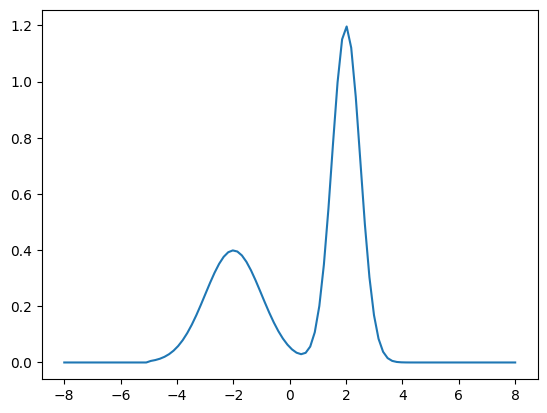

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


def p_pdf_unnormalized(x):
    return np.where(
        (x >= -5) & (x <= 5),
        stats.norm.pdf(x, -2, 1) + 1.5 * stats.norm.pdf(x, 2, 0.5),
        0,
    )


# Have a look at the distribution
x = np.linspace(-8, 8, 100)
y = p_pdf_unnormalized(x)
plt.plot(x, y)
plt.show()

Of course, this function is not easy to sample from (at least comparing to a Gaussian).

So we propose a function $q(x)$ that is easy to sample from, and satisfies:
$$
\exists \, M, s.t. \, \tilde{p}(x) \leq M q(x) , \forall x
$$

Of course, one of the easiest q(x) you can think of is a uniformed distribution over the support of the target distribution.
$$
q(x) = \frac{1}{10}, -5 \leq x \leq 5
$$

In [2]:
def q_pdf(x):
    return np.where((x >= -5) & (x <= 5), 1 / 10, 0)

Let us now consider the scaling factor $M$.
We can let $M$ be the ratio of the maximum value of $\tilde{p}(x)$ over the maximum value of $q(x)$,
and add a 10% margin to it.

In [3]:
x_grid = np.linspace(-5, 5, 1000)
p_values = p_pdf_unnormalized(x_grid)
q_values = q_pdf(x_grid)
M = 1.1 * np.max(p_values / q_values)  # Add 10% for safety

print(f"M = {M:.2f}")

M = 13.17


Now we are ready to implement the rejection sampling algorithm.

Remember, we will accept samples with probability:
$$
p_{accept}(x) = \frac{\tilde{p}(x)}{Mq(x)}
$$

This could be simulated by sampling uniformly in the y-axis, and accepting the sample if the y-coordinate is below the curve of the target distribution.


In [4]:
target_sample_amount = 10000

proposed_x = np.random.uniform(-5, 5, target_sample_amount)
proposed_y = np.random.uniform(0, M, target_sample_amount)
accepted = proposed_y < p_pdf_unnormalized(proposed_x) / q_pdf(proposed_x)
accepted_x = proposed_x[accepted]
accepted_y = proposed_y[accepted]
print(
    f"Accepted {len(accepted_x)} samples out of {target_sample_amount} proposed samples."
)

Accepted 1932 samples out of 10000 proposed samples.


Now let us visualize the samples.
If the histogram of the samples is similar to the target distribution, we can say that our rejection sampling works well.

But first, we need to get a normalized version of the target distribution.
`scipy` offers an integration module that can approximate the normalization constant for us.

Since the pdf must have an integral of 1, we can use the `scipy.integrate.quad` function to compute the integral of the target distribution.
Then we can divide the target distribution by this integral to get a normalized version.

In [5]:
from scipy import integrate

p_auc, _ = integrate.quad(p_pdf_unnormalized, -5, 5)
print(f"AUC of p: {p_auc}")

AUC of p: 2.4986501004872084


In [ ]:
# Devide the samples by the AUC to get a proper PDF
def p_pdf(x):
    return p_pdf_unnormalized(x) / p_auc

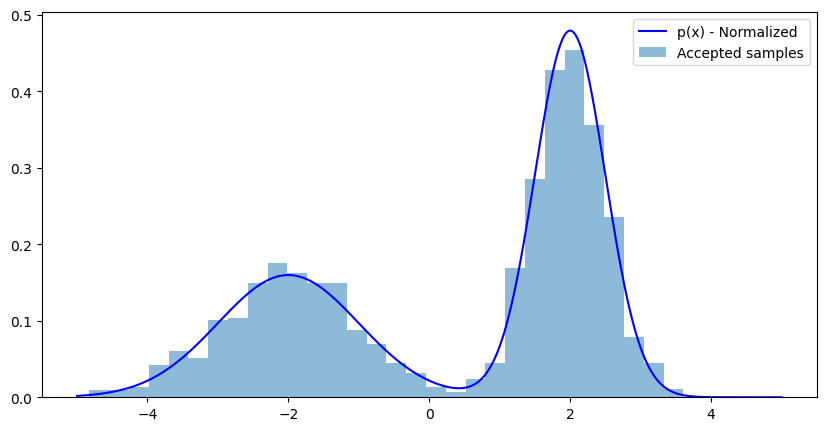

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(x_grid, p_pdf(x_grid), label="p(x) - Normalized", color="blue")
plt.hist(accepted_x, bins=30, density=True, alpha=0.5, label="Accepted samples")
plt.legend()
plt.show()

Looks good! 🎉

> 📚 **EXERCISE**
>
> - Think of a different function to sample from and try to implement your own rejection sampling!

## 2. Importance Sampling

Importance sampling is primarily used to evaluate the expectation of a function with respect to a target distribution $p(x)$, or, in other words:
$$
\mathbb{E}_{p}[f(x)] = \int f(x) p(x) dx
$$
where $f(x)$ is a function of interest, and $p(x)$ is the target distribution.

One way to estimate this expectation is using Monte Carlo methods, which involve sampling from the target distribution and averaging the function values.
$$
\hat{\mathbb{E}}_{p}[f(x)] = \frac{1}{N} \sum_{i=1}^{N} f(x_i), x_i \sim p(x)
\\
\hat{\mathbb{E}}_{p}[f(x)] \approx \mathbb{E}_{p}[f(x)]
$$

Importance sampling can reduce the variance of this estimate by sampling from a different distribution $q(x)$ that is:
- easier to evaluate and sample from
- is high when $|p(x)f(x)|$ is high

The formula for importance sampling is given by:
$$
\hat{\mathbb{E}_{p}}[f(x)] = 
\hat{\mathbb{E}}_{q}[\frac{p(x)}{q(x)} f(x)] = 
\frac{1}{N} \sum_{i=1}^{N} \frac{p(x_i)}{q(x_i)} f(x_i), x_i \sim q(x)
$$

In this section we will implement and demonstrate importance sampling's reduction of variance and the importance of the choice of $q(x)$.

If you wish to see a rigorous proof of the previous statements
(including how to evolve from Monte Carlo to importance sampling), check out this great [video](https://www.youtube.com/watch?v=C3p2wI4RAi8) on Youtube.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

Let's first start by defining the target distribution and the function we want to evaluate.

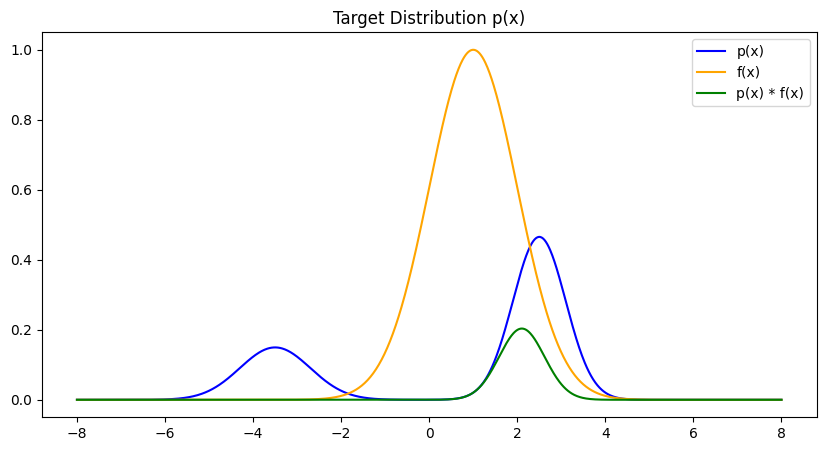

In [9]:
def p(x):
    # A mixture of two normal distributions
    return 0.3 * stats.norm.pdf(x, -3.5, 0.8) + 0.7 * stats.norm.pdf(x, 2.5, 0.6)


def f(x):
    return np.exp(-0.5 * (x - 1) ** 2)


plt.figure(figsize=(10, 5))
x = np.linspace(-8, 8, 1000)
plt.plot(x, p(x), label="p(x)", color="blue")
plt.plot(x, f(x), label="f(x)", color="orange")
plt.plot(x, p(x) * f(x), label="p(x) * f(x)", color="green")
plt.title("Target Distribution p(x)")
plt.legend()
plt.show()

Great! We will then evaluate the true expectation using numerical integration.

In [10]:
from scipy import integrate

pf_auc, _ = integrate.quad(lambda x: p(x) * f(x), -np.inf, np.inf)
print(f"Ground truth expectation of f(x): {pf_auc}")

Ground truth expectation of f(x): 0.26295681556072614


Let's first try the naive Monte Carlo method.

We have chosen a mixture of two Gaussian distribution, so we can use the two-step process:
- Randomly select a Gaussian distribution by its weight
- Sample from the selected Gaussian distribution

Note that in reality $p(x)$ is usually difficult to sample from, so here is merely for demonstration purposes.

In [11]:
"""
Recall that
def p(x):
    # A mixture of two normal distributions
    return 0.3 * stats.norm.pdf(x, -3.5, 0.8) + 0.7 * stats.norm.pdf(x, 2.5, 0.6)
"""


def standard_monte_carlo(n_samples):
    samples = []
    while len(samples) < n_samples:
        # Sample from the mixture components directly
        if np.random.random() < 0.3:
            samples.append(np.random.normal(-3.5, 0.8))
        else:
            samples.append(np.random.normal(2.5, 0.6))
    samples = np.array(samples)
    # Evaluate f(x) at the sampled points
    f_values = f(samples)
    # Calculate the average of f(x) over the samples
    expectation = np.mean(f_values)
    return expectation

Now, let's implement the importance sampling algorithm.

We let the proposal distribution $q(x)$ be a Gaussian distribution.

In [12]:
def importance_sampling(n_samples, proposal_gaussian_mu, proposal_gaussian_sigma):
    q_fn = stats.norm(proposal_gaussian_mu, proposal_gaussian_sigma)
    x_samples = np.random.normal(
        proposal_gaussian_mu, proposal_gaussian_sigma, n_samples
    )
    # Calculate the weights (p(x) / q(x))
    weights = p(x_samples) / q_fn.pdf(x_samples)
    # Calculate the weighted average of f(x)
    f_values = f(x_samples)
    weighted_f_values = f_values * weights
    expectation = np.mean(weighted_f_values)
    return expectation

Great! Now we run the estimation process multiple times and plot the results to investigate the variance of the estimates.

Let us propose a relatively "good" q(x) which has $\mu = 2, \sigma = 0.5$, close to the peak of $p(x)f(x)$.

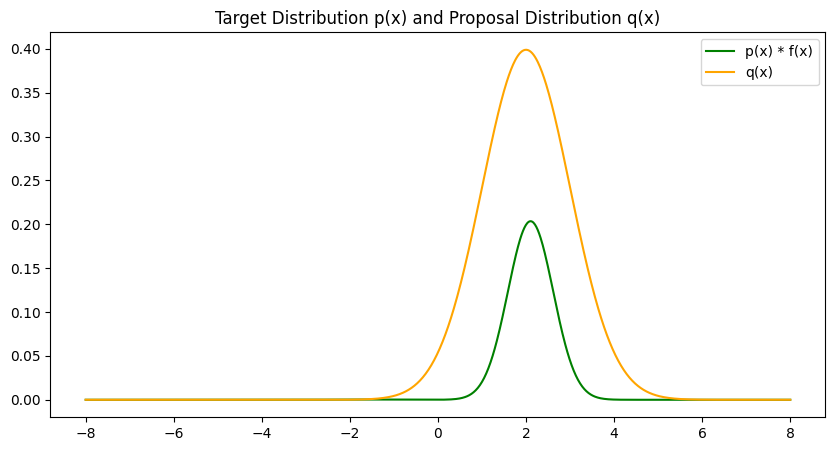

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(x, p(x) * f(x), label="p(x) * f(x)", color="green")
plt.plot(x, stats.norm.pdf(x, 2, 1), label="q(x)", color="orange")
plt.title("Target Distribution p(x) and Proposal Distribution q(x)")
plt.legend()
plt.show()

Standard Monte Carlo mean: 0.263835
Importance Sampling mean: 0.262616
Standard Monte Carlo variance: 0.000723
Importance Sampling variance: 0.000031


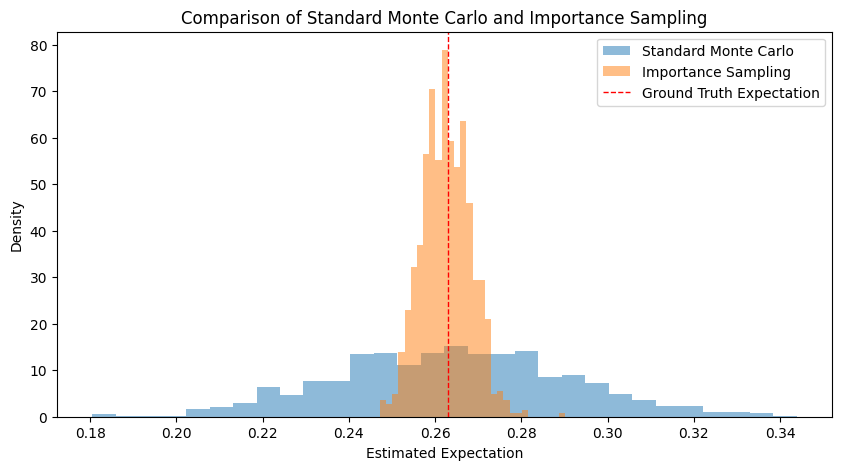

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
# Run the comparison
N_RUNS = 1000
N_SAMPLES = 100
standard_monte_carlo_results_tmp = []
importance_sampling_results_tmp = []
for _ in range(N_RUNS):
    standard_monte_carlo_results_tmp.append(standard_monte_carlo(N_SAMPLES))
    importance_sampling_results_tmp.append(
        importance_sampling(
            N_SAMPLES, proposal_gaussian_mu=2, proposal_gaussian_sigma=0.5
        )
    )
standard_monte_carlo_results = np.array(standard_monte_carlo_results_tmp)
importance_sampling_results = np.array(importance_sampling_results_tmp)
standard_monte_carlo_mean = np.mean(standard_monte_carlo_results)
importance_sampling_mean = np.mean(importance_sampling_results)
print(f"Standard Monte Carlo mean: {standard_monte_carlo_mean:.6f}")
print(f"Importance Sampling mean: {importance_sampling_mean:.6f}")
standard_monte_carlo_var = np.var(standard_monte_carlo_results)
importance_sampling_var = np.var(importance_sampling_results)
print(f"Standard Monte Carlo variance: {standard_monte_carlo_var:.6f}")
print(f"Importance Sampling variance: {importance_sampling_var:.6f}")
# Plot histograms of the results
plt.figure(figsize=(10, 5))
plt.hist(
    standard_monte_carlo_results,
    bins=30,
    density=True,
    alpha=0.5,
    label="Standard Monte Carlo",
)
plt.hist(
    importance_sampling_results,
    bins=30,
    density=True,
    alpha=0.5,
    label="Importance Sampling",
)
plt.axvline(
    pf_auc,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Ground Truth Expectation",
)
plt.title("Comparison of Standard Monte Carlo and Importance Sampling")
plt.xlabel("Estimated Expectation")
plt.ylabel("Density")
plt.legend()
plt.show()

However, we can demonstrate that, even if we choose a slightly worse q(x), the variance of the estimates will increase significantly.

Let us say, if we choose a q(x) with $\mu = 3, \sigma = 0.5$, which is not "too far" from the peak of $p(x)f(x)$...

Standard Monte Carlo mean: 0.263835
Importance Sampling mean: 0.264378
Standard Monte Carlo variance: 0.000723
Importance Sampling variance: 0.014339


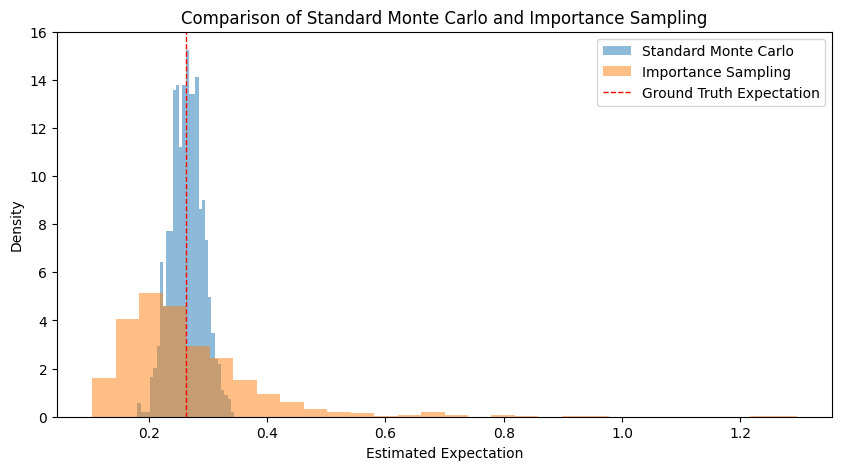

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
# Run the comparison
N_RUNS = 1000
N_SAMPLES = 100
standard_monte_carlo_results_tmp = []
importance_sampling_results_tmp = []
for _ in range(N_RUNS):
    standard_monte_carlo_results_tmp.append(standard_monte_carlo(N_SAMPLES))
    importance_sampling_results_tmp.append(
        importance_sampling(
            N_SAMPLES, proposal_gaussian_mu=3, proposal_gaussian_sigma=0.5
        )
    )
standard_monte_carlo_results = np.array(standard_monte_carlo_results_tmp)
importance_sampling_results = np.array(importance_sampling_results_tmp)
standard_monte_carlo_mean = np.mean(standard_monte_carlo_results)
importance_sampling_mean = np.mean(importance_sampling_results)
print(f"Standard Monte Carlo mean: {standard_monte_carlo_mean:.6f}")
print(f"Importance Sampling mean: {importance_sampling_mean:.6f}")
standard_monte_carlo_var = np.var(standard_monte_carlo_results)
importance_sampling_var = np.var(importance_sampling_results)
print(f"Standard Monte Carlo variance: {standard_monte_carlo_var:.6f}")
print(f"Importance Sampling variance: {importance_sampling_var:.6f}")
# Plot histograms of the results
plt.figure(figsize=(10, 5))
plt.hist(
    standard_monte_carlo_results,
    bins=30,
    density=True,
    alpha=0.5,
    label="Standard Monte Carlo",
)
plt.hist(
    importance_sampling_results,
    bins=30,
    density=True,
    alpha=0.5,
    label="Importance Sampling",
)
plt.axvline(
    pf_auc,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Ground Truth Expectation",
)
plt.title("Comparison of Standard Monte Carlo and Importance Sampling")
plt.xlabel("Estimated Expectation")
plt.ylabel("Density")
plt.legend()
plt.show()

> 🤔 **THINKING**
>
> - Based on this observation, what do you think is the greatest challenge of importance sampling?